# Pattern analysis
---

## Evaluation

We evalute the result of our method, *i.e. pattern summaries* according to the information they carry. For this purpose, we define 3 metrics: 
- *Diversity*: coverage of a large number of topics from the original graph is a great summarization quality 
- *Coverage*: we can hypothetize that a summary is more informative if it captures a large amount of entites from the original graph
- *Conciseness*: for human-readability as well as explainability, conciseness of the result is crucial 

**Diversity**: $Diversity(SG)=\dfrac{|\{(ps_i, ps_j), d(ps_i, ps_j) > \delta, \forall i \neq j, ps \in SG\}|}{|P|}$, with $P$ the list of all patterns, $SG$ a summarized graph and $ps$ a pattern summary. It number of distinct pairs of pattern summaries which exhibit a pairwise distance above a threshold. Distance $d$ can be evaluated using Wasserstein distance between pattern summary representations for example.

**Coverage**: $Coverage(SG)=\dfrac{|\{u, u \in SG\}|}{|\mathcal{V}|}$ is the proportion of nodes in the summary compared to the total number of nodes in the original graph.

**Conciseness**: $Conciseness(SG)= M(|\{u, u \in ps, \forall ps \in SG|\}) + M(|\{a, a \in ps, \forall ps \in SG|\})$, where $M$ denotes the median. A summary graph is concise if it contains few nodes and attributes, since it will be easier to interpret it. 

All together, we evalute a summary graph using the information $I$ it carries:
$$
I(SG) = \dfrac{Diversity(SG) \times Coverage(SG)}{\sqrt{Conciseness(SG)}}
$$

In [236]:
from collections import defaultdict
from IPython.display import SVG
import numpy as np
import pickle
from scipy import sparse
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sknetwork.data import load_netset
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees
from sknetwork.visualization import svg_graph

In [261]:
def load_data(dataset):
    graph = load_netset(dataset)
    adjacency = graph.adjacency
    biadjacency = graph.biadjacency
    names = graph.names
    names_col = graph.names_col
    labels = graph.labels
    return adjacency, biadjacency, names, names_col, labels

def load_patterns(dataset, b, s, order):
    with open(f"../output/result/result_{dataset}_{b}_{s}_order{str(order)}.bin", "rb") as data:
        patterns = pickle.load(data)
    return patterns

def preprocess_data(biadjacency, names_col, s):
    # Frequent attributes
    freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

    # Filter data with index
    biadjacency = biadjacency[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Sort data
    sort_index = np.argsort(freq_attribute)
    sorted_biadjacency = biadjacency[:, sort_index]
    words = words[sort_index]
    return sorted_biadjacency, words

def get_pattern(patterns, i):
    return patterns[i][0], patterns[i][1]

def get_summarized_graph(adjacency, patterns):
    """Get summarized graph given patterns and original adjacency matrix."""
    
    rows, cols = [], []

    for p in patterns:

        # exclude first element of lattice 
        if len(p[1]) > 0:
            nodes = sorted(p[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_pattern = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_pattern.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_pattern.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def get_summarized_biadjacency(adjacency, biadjacency, patterns):
    summarized_biadj = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
    for p in patterns:
        if len(p[1]) > 0:
            for node in p[0]:
                summarized_biadj[node, p[1]] += 1

    summarized_biadj = sparse.csr_matrix(summarized_biadj.astype(bool), shape=summarized_biadj.shape)
    return summarized_biadj

def get_pattern_summaries(summarized_adjacency):
    # Summarized graph filtered on used nodes
    mask = np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1])))
    
    # Number of connected components (NOT considering isolated nodes)
    labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
    
    return labels_cc_summarized, mask    

def get_pw_distance_matrix(dataset, b, s, method='summaries'):
    with open(f'../output/result/wasserstein_distances_{dataset}_{b}_{s}_{method}.pkl', 'rb') as data:
        pw_distances = np.load(data)
    return pw_distances

def decay(values, lamb=200):
    return np.exp(values / lamb)

def get_diversity(pw_distances, delta=0.2):
    n = pw_distances.shape[0]
    upper = pw_distances[np.triu_indices(n)]
    nb_ps = np.sum(upper > delta)
    print(pw_distances.shape, len(upper), nb_ps)
    return nb_ps / len(upper)

def get_coverage(summarized_adjacency):
    # number of nodes in summarized graph
    n_nodes = len(np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1]))))
    
    # Coverage
    cov = n_nodes / summarized_adjacency.shape[0]
    
    return cov

def get_conciseness(summarized_adjacency, summarized_biadjacency):
    n, m = summarized_adjacency.shape[1], summarized_biadjacency.shape[1]

    out_deg_nodes = summarized_adjacency.astype(bool).dot(np.ones(n))
    nb_nodes_ps = out_deg_nodes[out_deg_nodes > 0]
    out_deg_attrs = summarized_biadjacency.astype(bool).dot(np.ones(m))
    nb_attrs_ps = out_deg_attrs[out_deg_attrs > 0]
    print(np.median(nb_nodes_ps), np.median(nb_attrs_ps))
    
    return np.median(nb_nodes_ps) + np.median(nb_attrs_ps)

def get_information_sg(summarized_adjacency, summarized_biadjacency, pw_distances):
    div = get_diversity(pw_distances)
    cov = get_coverage(summarized_adjacency)
    conc = get_conciseness(summarized_adjacency, summarized_biadjacency) 
    information = (div * cov) / np.sqrt(conc)
    print(f'inf: {information} - div: {div} - cov: {cov} - conc: {np.sqrt(conc)}')
    return information 

**Output evaluation**

In [240]:
from sknetwork.clustering import Louvain

# Louvain
resolutions = {'wikivitals-fr': {1: 0, 3: 0, 5: 0.3, 6: 0.4, 10: 0.8, 12: 0.9, 15: 1.1, 47: 3, 27: 1.89}, 
                'wikivitals': {4: 0.5, 7: 0.8, 11: 1, 13: 1.3, 14: 1.18, 16: 1.5, 19: 1.6, 21: 1.76, 29: 2.4, 31: 2.5, 34: 2.7, 47: 3.903, 49: 3.95, 65: 4.70, 101: 6.4}, 
                'wikischools': {4: 0.45, 8: 1, 3: 0.4, 8: 0.58, 9: 0.9, 10: 1.18, 13: 1.4, 15: 1.5, 18: 1.69, 22: 1.95, 39: 2.75, 40: 2.75,  46: 2.99, 58: 3.7, 73: 4.41}}

def get_louvain(dataset, adjacency, nb_cc):
    louvain = Louvain(resolution=resolutions.get(dataset).get(nb_cc)) 
    labels_louvain = louvain.fit_transform(adjacency)
    nb_louvain = len(np.unique(labels_louvain))
    return labels_louvain

In [241]:
def get_community_graph(adjacency, labels_communities):
    n_com = len(np.unique(labels_communities))
    rows, cols = [], []
    for n in range(n_com):
        nodes = np.flatnonzero(labels_communities == n)
        idx = 0
        idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from communities
        # reindex nodes
        for n in nodes:
            if n not in idx_nodes:
                idx_nodes[idx] = n
                idx += 1

        # Record edges from subgraph related to community
        adj_com = adjacency[nodes, :][:, nodes].tocoo()
        reindex_rows = [int(idx_nodes[src]) for src in adj_com.row]
        reindex_cols = [int(idx_nodes[dst]) for dst in adj_com.col]
        rows += reindex_rows
        cols += reindex_cols
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

In [242]:
def pattern_attributes(biadjacency, labels):
    """Build pattern x attributes matrix. Column values are count of occurrences of attributes for each pattern/community.
    
    Parameters
    ----------
    biadjacency: sparse.csr_matrix
        Biadjacency matrix of the graph
    labels: np.ndarray
        Belonging community for each node in the graph, e.g Louvain labels or KMeans labels
        
    Outputs
    -------
        Matrix with patterns/communities in rows and count of attributes in columns. """

    nb_cc = len(np.unique(labels))
    matrix = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = labels == c
        indices_attr = biadjacency[mask_cc].indices
        for ind in indices_attr:
            matrix[c, ind] += 1

    return matrix

In [293]:
datasets = ['wikivitals-fr']
betas = [5]
ss = [8, 7]
with_order = [True]
delta = 0.2
informations = defaultdict()

for d, dataset in enumerate(datasets):
    informations[dataset] = defaultdict(dict)
    # Load data
    adjacency, biadjacency, names, names_col, labels = load_data(dataset)
    print(f'Dataset: {dataset}...')
        
    for i, b in enumerate(betas):
        informations[dataset][b] = defaultdict(list)
        for k, s in enumerate(ss):
            
            new_biadjacency, words = preprocess_data(biadjacency, names_col, s)
            
            # Load patterns
            patterns = load_patterns(dataset, b, s, True)
            
            # Summarized graph + features
            summarized_adj = get_summarized_graph(adjacency, patterns)
            summarized_biadj = get_summarized_biadjacency(adjacency, new_biadjacency, patterns)
            
            # Pattern summaries 
            pattern_summary_labels, mask = get_pattern_summaries(summarized_adj)
            
            # Louvain
            louvain_labels = get_louvain(dataset, adjacency, len(np.unique(pattern_summary_labels)))
            pattern_louvain_attributes = pattern_attributes(biadjacency, louvain_labels)
            louvain_adj = get_community_graph(adjacency, louvain_labels)
            
            # Pattern summary pariwise distances
            pw_distances_summaries = get_pw_distance_matrix(dataset, b, s, method='summaries')
            pw_distances_louvain = get_pw_distance_matrix(dataset, b, s, method='louvain')
            
            # SG information
            print(f'summaries')
            information_summaries = get_information_sg(summarized_adj, summarized_biadj, pw_distances_summaries)
            print('louvain')
            information_louvain = get_information_sg(louvain_adj, pattern_louvain_attributes, pw_distances_louvain)
            
            informations[dataset][b]['summaries'].append(information_summaries)
            informations[dataset][b]['louvain'].append(information_louvain)

Parsing files...
Done.
Dataset: wikivitals-fr...
summaries
(1, 1) 1 0
2.0 16.0
inf: 0.0 - div: 0.0 - cov: 0.00130718954248366 - conc: 4.242640687119285
louvain
(4, 4) 10 5
40.0 40.5
inf: 0.05567178523817124 - div: 0.5 - cov: 0.9989944695827049 - conc: 8.972179222463181
summaries
(6, 6) 21 9
6.0 9.0
inf: 0.0005674700873563981 - div: 0.42857142857142855 - cov: 0.005128205128205128 - conc: 3.872983346207417
louvain
(5, 5) 15 6
36.0 46.0
inf: 0.044119310145860256 - div: 0.4 - cov: 0.9987933634992459 - conc: 9.055385138137417


In [290]:
sorted(pattern_louvain_attributes.astype(bool).dot(np.ones(pattern_louvain_attributes.shape[1])), reverse=True)

[11179.0,
 10669.0,
 10375.0,
 9973.0,
 9259.0,
 9149.0,
 9014.0,
 8614.0,
 8267.0,
 7960.0,
 7659.0,
 7563.0,
 7540.0,
 7235.0,
 7226.0,
 6816.0,
 6798.0,
 6776.0,
 6637.0,
 6433.0,
 6338.0,
 5951.0,
 5133.0,
 4620.0,
 4012.0,
 3770.0,
 3756.0,
 2375.0,
 1223.0]

In [291]:
np.median(pattern_louvain_attributes.astype(bool).dot(np.ones(pattern_louvain_attributes.shape[1])))

7226.0

In [292]:
from collections import Counter

Counter(louvain_labels)

Counter({4: 568,
         7: 443,
         8: 436,
         12: 389,
         11: 399,
         18: 254,
         5: 508,
         2: 592,
         1: 618,
         10: 411,
         6: 449,
         21: 224,
         17: 290,
         0: 742,
         15: 340,
         25: 108,
         3: 584,
         16: 316,
         24: 136,
         9: 416,
         19: 239,
         27: 72,
         23: 175,
         14: 383,
         20: 237,
         26: 73,
         13: 384,
         22: 203,
         28: 22})

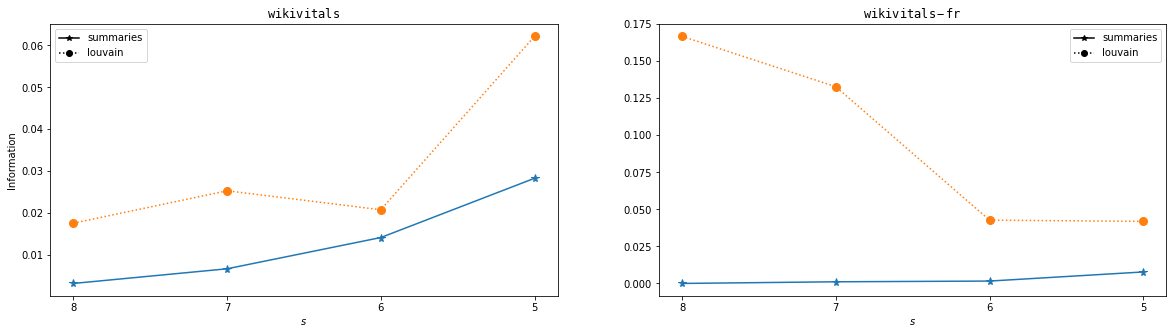

In [253]:
markers = ['*', 'o', '^', '+']
styles = [(0, (3, 10, 1, 10)), 'dashed', 'dotted', 'solid']

fig, ax = plt.subplots(1, len(datasets), figsize=(20, 5))

legend_elements = [Line2D([0], [0], color='black', marker='*', linestyle=styles[3], label=r'summaries'),
                   Line2D([0], [0], color='black', marker='o', linestyle=styles[2], label=r'louvain'),
                   #Line2D([0], [0], color='black', marker='^', linestyle=styles[2], label=r'$\beta$=6'),
                   #Line2D([0], [0], color='black', marker='+', linestyle=styles[3], label=r'$\beta$=5'),
                   ]

for i, d in enumerate(datasets):
    #for j, b in enumerate(betas):
    ax[i].plot(informations.get(d).get(5).get('summaries'), marker=markers[0], linestyle=styles[3], markersize=8)
    ax[i].plot(informations.get(d).get(5).get('louvain'), marker=markers[1], linestyle=styles[2], markersize=8)
    ax[i].set_xticks(np.arange(0, len(ss)), labels=['8', '7', '6', '5'])
    ax[i].set_title(rf"$\tt{d}$")
    ax[i].set_xlabel(r'$s$')
    ax[i].legend(handles=legend_elements)
    if i == 0:
        ax[i].set_ylabel('Information')

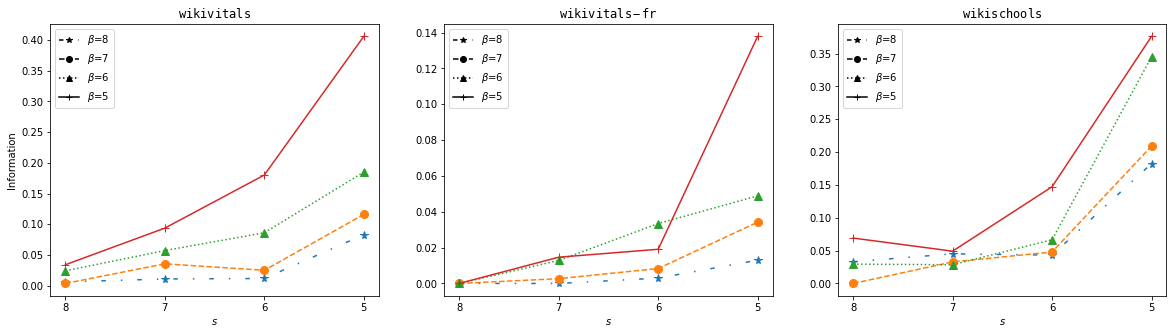

In [130]:
from matplotlib.lines import Line2D

markers = ['*', 'o', '^', '+']
styles = [(0, (3, 10, 1, 10)), 'dashed', 'dotted', 'solid']

fig, ax = plt.subplots(1, len(datasets), figsize=(20, 5))

legend_elements = [Line2D([0], [0], color='black', marker='*', linestyle=styles[0], label=r'$\beta$=8'),
                   Line2D([0], [0], color='black', marker='o', linestyle=styles[1], label=r'$\beta$=7'),
                   Line2D([0], [0], color='black', marker='^', linestyle=styles[2], label=r'$\beta$=6'),
                   Line2D([0], [0], color='black', marker='+', linestyle=styles[3], label=r'$\beta$=5'),
                   ]

for i, d in enumerate(datasets):
    for j, b in enumerate(betas):
        ax[i].plot(informations.get(d).get(b), marker=markers[j], linestyle=styles[j], markersize=8)
        ax[i].set_xticks(np.arange(0, len(ss)), labels=['8', '7', '6', '5'])
        ax[i].set_title(rf"$\tt{d}$")
        ax[i].set_xlabel(r'$s$')
        ax[i].legend(handles=legend_elements)
        if i == 0:
            ax[i].set_ylabel('Information')

## All datasets

In [280]:
# Load data
with open('../output/result/informations_evaluation.pkl', 'rb') as data:
    info_eval = pickle.load(data)

In [281]:
info_eval.get('wikivitals-fr').get(5)

defaultdict(list,
            {'summaries': [0.0,
              0.05674700873563981,
              0.07625272331154684,
              0.4359916369018451],
             'louvain': [5.567178523817124,
              4.411931014586026,
              0.17551201996051394,
              0.2465614399209034],
             'gnn': [0.0, 0.0, 0.0, 0.16792433242358132],
             'spectral': [0.0, 0.0, 0.0, 0.07664012492205383],
             'doc2vec': [0.0, 0.0, 0.004267283054499062, 0.0316505694935554]})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


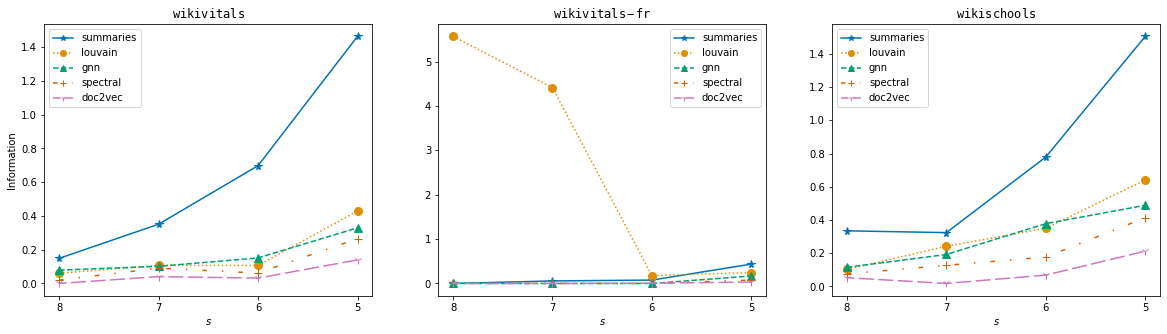

In [296]:
rgb_values = sns.color_palette("colorblind", 8)
    
# Plot result
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
markers = ['*', 'o', '^', '+', '1']
styles = ['solid', 'dotted', 'dashed', (0, (3, 10, 1, 10)), (5, (10, 3))]
labels = ['summaries', 'louvain', 'gnn', 'spectral', 'doc2vec']
ss = [8, 7, 6, 5]

fig, ax = plt.subplots(1, len(datasets), figsize=(20, 5))
legend_elements = [Line2D([0], [0], marker=markers[i], linestyle=styles[i], label=labels[i], color=rgb_values[i]) for i in range(5)]

for i, d in enumerate(datasets):
    for j in range(len(labels)):
        ax[i].plot(info_eval.get(d).get(5).get(labels[j]), marker=markers[j], linestyle=styles[j], markersize=8, color=rgb_values[j])
    ax[i].set_xticks(np.arange(0, len(ss)), labels=['8', '7', '6', '5'])
    ax[i].set_title(rf"$\tt{d}$")
    ax[i].set_xlabel(r'$s$')
    #ax[i].set_yscale('log')
    ax[i].legend(handles=legend_elements)
    
    if i == 0:
        ax[i].set_ylabel('Information')
        
# Save image
plt.savefig('../output/img/information_evaluation.eps', dpi=200, bbox_inches='tight')

On `wikivitals-fr` dataset, for low values of $s$, Louvain algorithm produces one very large community, and a few really small ones. Thus, the conciseness (which is the median of the number of nodes and attributes in communities) is relatively small compared to other values of $s$ or other datasets where the nodes are better separated in each community. Nevertheless, we see that when the number of communities grows (i.e. higher values of $s$), the information carried out by Louvain communities drops drastically and that our method outperforms all baselines.

### For other values of $\beta$

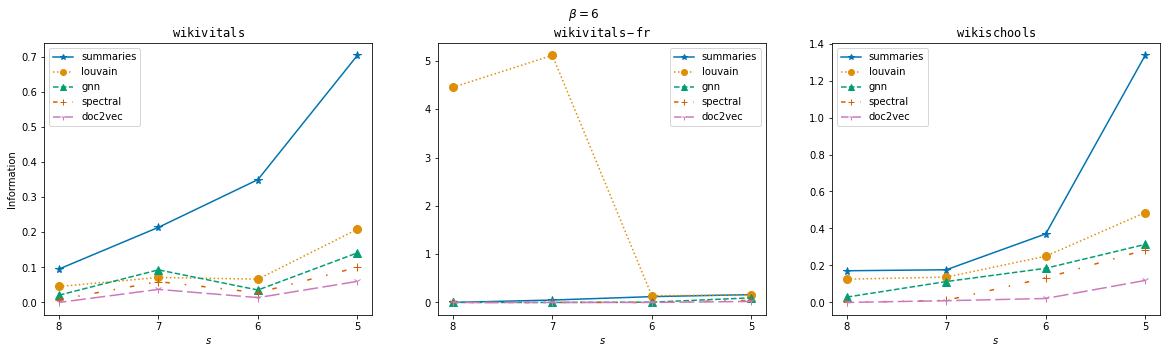

In [300]:
display_inf_plot(info_eval, beta=6)

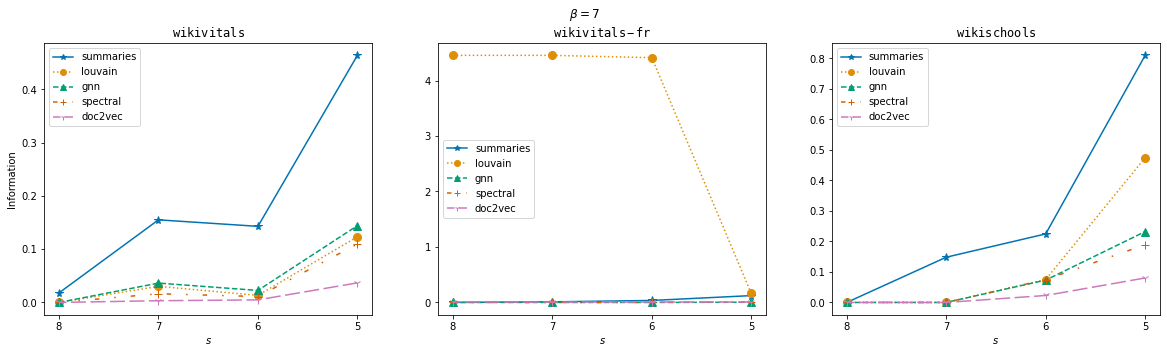

In [301]:
display_inf_plot(info_eval, beta=7)

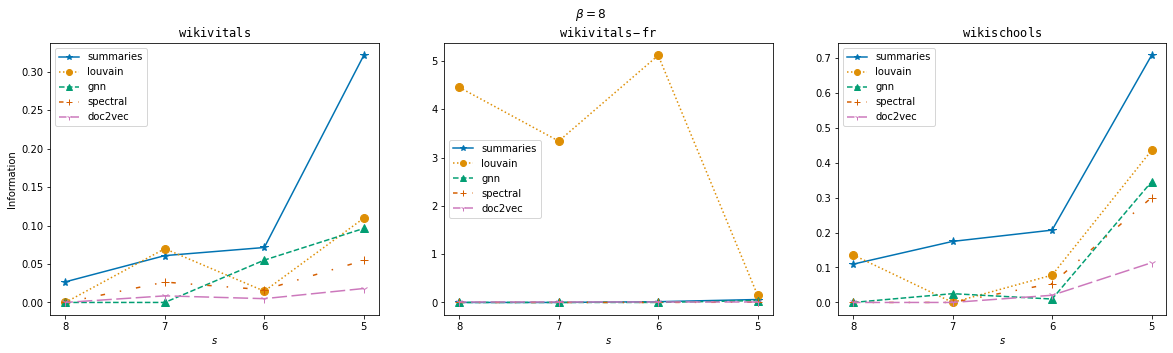

In [302]:
display_inf_plot(info_eval, beta=8)